<a href="https://colab.research.google.com/github/MMillward2012/deepmind_internship/blob/main/notebooks/8_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universal Model Explainability Dashboard
This notebook provides a comprehensive dashboard for explaining financial sentiment models. It is structured in two parts:

- **Part A**: Individual Prediction Analysis: Focuses on explaining single sentences, either by analyzing model mistakes or through an interactive dashboard.

- **Part B**: Systemic Error Analysis: Moves beyond single examples to find patterns in model failures by aggregating explanations.

In [1]:
%cd ..

/Users/matthew/Documents/deepmind_internship


In [2]:
!ls

README.md        models           requirements.txt venv-py311
data             notebooks        results
figures          old_notebooks    src


## 1. Configuration

Set the `MODEL_NAME` variable below to the name of the model you wish to analyze. The rest of the notebook will adapt automatically.

In [32]:
# --- Configuration ---
# Change this to analyze any of your compatible models (e.g., "tinybert-...", "mobilebert-...")
MODEL_NAME = "tinybert-financial-classifier"
DATA_FILE_PATH = "data/FinancialPhraseBank/all-data.csv"
RANDOM_SEED = 42
TEST_SIZE = 0.25

## 2. Setup and Resource Loading

This block handles all setup, installing libraries and loading assets for the selected model: the tokenizer, ONNX model, PyTorch model, label encoder, and test data.

In [33]:
# --- Environment Setup ---
import pandas as pd
import numpy as np
import shap
import onnxruntime as ort
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pathlib import Path
import platform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
from bertviz import model_view
from IPython.display import display, clear_output
import ipywidgets as widgets
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns


# --- Asset Loading ---
MODEL_DIR = Path("models") / MODEL_NAME
ONNX_PATH = MODEL_DIR / "onnx" / "model.onnx"

print(f"--- Loading assets for model: {MODEL_NAME} ---")

# Load Tokenizer (used by all components)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

# Load ONNX session for fast predictions
providers = ['CPUExecutionProvider']
if platform.system() == "Darwin" and ort.get_device() == "ARM64":
    providers = [('CoreMLExecutionProvider', {'coreml_flags': 'COREML_FLAG_ENABLE_ON_SUBGRAPH'}), 'CPUExecutionProvider']
session = ort.InferenceSession(str(ONNX_PATH), providers=providers)

# Load PyTorch model for attention visualization
pt_model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
pt_model.eval()

# Load Label Encoder
with open(MODEL_DIR / "label_encoder.pkl", 'rb') as f:
    label_encoder = pickle.load(f)

# Re-create the exact test set
df = pd.read_csv(DATA_FILE_PATH, header=None, names=['sentiment', 'text'], encoding='latin-1')
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=df['sentiment'])

test_texts = test_df['text'].tolist()
true_labels_encoded = label_encoder.transform(test_df['sentiment'])

print(f"✅ Setup complete. Loaded {len(test_texts)} test samples.")

--- Loading assets for model: tinybert-financial-classifier ---
✅ Setup complete. Loaded 1212 test samples.


## 3. Model Prediction Functions

These functions get predictions from the ONNX model. `predict_class` returns the final label, while `predict_logits_for_shap` returns the raw outputs required by SHAP.

In [34]:
def predict_class(texts):
    """Prediction function that returns final class predictions (0, 1, or 2)."""
    if isinstance(texts, str): texts = [texts]
    if len(texts) == 0: return np.array([])
    
    encoding = tokenizer(list(texts), return_tensors="np", padding=True, truncation=True, max_length=128)
    model_inputs = {inp.name for inp in session.get_inputs()}
    valid_inputs = {k: v for k, v in encoding.items() if k in model_inputs}
    
    outputs = session.run(None, valid_inputs)
    logits = outputs[0]
    return np.argmax(logits, axis=1)

def predict_logits_for_shap(texts):
    """Prediction function for SHAP that returns raw model logits."""
    if isinstance(texts, str): texts = [texts]
    if len(texts) == 0: return np.array([])
        
    encoding = tokenizer(list(texts), return_tensors="np", padding=True, truncation=True, max_length=128)
    model_inputs = {inp.name for inp in session.get_inputs()}
    valid_inputs = {k: v for k, v in encoding.items() if k in model_inputs}
    
    outputs = session.run(None, valid_inputs)
    return outputs[0]

## 4. The Explainability Toolbox

This section contains our modular explanation functions. Each is responsible for generating one type of visual.

In [35]:
def explain_with_shap(shap_values_for_class):
    """Displays the SHAP text plot for a given set of pre-calculated SHAP values."""
    print("\n--- SHAP View (Why did the model choose this class?) ---")
    display(shap.plots.text(shap_values_for_class))

def explain_with_attention(text, pt_model, tokenizer):
    """Displays the bertviz attention head view for a given text."""
    print("\n--- Attention View (How did the model connect the words?) ---")
    inputs = tokenizer(text, return_tensors='pt')
    outputs = pt_model(**inputs, output_attentions=True)
    attention_scores = outputs.attentions
    
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    vis = model_view(attention=attention_scores, tokens=tokens)
    display(vis)

# Part A: Individual Prediction Analysis
This part focuses on explaining single sentences, either by analyzing model mistakes or through an interactive dashboard.

## 5. Analysis of Model Mistakes

This block finds examples in the test set that the model predicted incorrectly and generates a detailed report for a few of them.

In [36]:
# --- Find Incorrect Predictions ---
predictions_encoded = predict_class(test_texts)
incorrect_indices = np.where(predictions_encoded != true_labels_encoded)[0]
print(f"Found {len(incorrect_indices)} incorrect predictions out of {len(test_texts)} total for model '{MODEL_NAME}'.")

# --- Build the SHAP Explainer (do this once) ---
explainer = shap.Explainer(predict_logits_for_shap, tokenizer)

# --- Analyze and Explain a Few Mistakes ---
num_examples_to_show = 3
incorrect_samples_to_explain = [test_texts[i] for i in incorrect_indices[:num_examples_to_show]]

if incorrect_samples_to_explain:
    shap_values = explainer(incorrect_samples_to_explain)

    for i in range(len(incorrect_samples_to_explain)):
        sample_index = incorrect_indices[i]
        text_sample = test_texts[sample_index]
        true_label_name = label_encoder.inverse_transform([true_labels_encoded[sample_index]])[0]
        pred_label_name = label_encoder.inverse_transform([predictions_encoded[sample_index]])[0]
        
        print(f"\n{'='*25} Explaining Mistake #{i+1} {'='*25}")
        print(f"Text: '{text_sample}'")
        print(f"True Label: '{true_label_name}' | Model Predicted: '{pred_label_name}'")
        
        shap_instance_for_predicted_class = shap_values[i, :, predictions_encoded[sample_index]]
        explain_with_shap(shap_instance_for_predicted_class)
        # explain_with_attention(text_sample, pt_model, tokenizer)
else:
    print("✅ No incorrect predictions to explain!")

Found 253 incorrect predictions out of 1212 total for model 'tinybert-financial-classifier'.

========================= Explaining Mistake #1 =========================
Text: 'Le Lay succeeds Walter G++nter and will be based in Finland .'
True Label: 'neutral' | Model Predicted: 'positive'

--- SHAP View (Why did the model choose this class?) ---


None


========================= Explaining Mistake #2 =========================
Text: 'Calls to the switchboard and directory services have decreased significantly since our employees now have up-to-date contact information from all their colleagues and customers on their phone and can place the call directly .'
True Label: 'neutral' | Model Predicted: 'negative'

--- SHAP View (Why did the model choose this class?) ---


None


========================= Explaining Mistake #3 =========================
Text: 'The Finnish real estate investment company Interavanti Oyj said on Monday ( 22 September ) that it has agreed to sell its 65 % ownership in the Finnish ticket service company Lippupiste Oy to CTS Eventim AG ( 56,1 % ) and to the managing director of Lippupiste Oy .'
True Label: 'neutral' | Model Predicted: 'positive'

--- SHAP View (Why did the model choose this class?) ---


None

## 6. Interactive Explainer

This section provides a simple dashboard to analyze any sentence you type in, allowing for live, free-form exploration of the model's behavior.

In [37]:
# --- Create UI elements ---
text_input = widgets.Text(placeholder="Enter a sentence to analyze...", layout=widgets.Layout(width='90%'))
submit_button = widgets.Button(description="Explain", button_style='success')
output_area = widgets.Output()

# --- Define the function to run on button click ---
def on_button_click(b):
    with output_area:
        clear_output() 
        text = text_input.value
        if not text:
            print("Please enter some text.")
            return

        print("--- Analyzing New Text ---")
        
        prediction_encoded = predict_class(text)[0]
        shap_values = explainer([text])
        pred_label_name = label_encoder.inverse_transform([prediction_encoded])[0]
        
        print(f"Text: '{text}'")
        print(f"Model Predicted: '{pred_label_name}'")

        shap_instance_for_predicted_class = shap_values[0, :, prediction_encoded]
        explain_with_shap(shap_instance_for_predicted_class)
        explain_with_attention(text, pt_model, tokenizer)

# --- Link the function and display the UI ---
submit_button.on_click(on_button_click)
print("Enter text below to get a live explanation:")
display(text_input, submit_button, output_area)

Enter text below to get a live explanation:


Text(value='', layout=Layout(width='90%'), placeholder='Enter a sentence to analyze...')

Button(button_style='success', description='Explain', style=ButtonStyle())

Output()

# Part B: Systemic Error Analysis
This new section moves beyond single examples to find patterns in the model's failures by aggregating explanations across many similar errors.

## 7. Aggregated Error Analysis: Finding "Culprit" Words

This section automatically loops through every possible incorrect prediction type (e.g., Neutral -> Positive, Positive -> Neutral, etc.) and generates a report showing the words that most consistently cause each error.

PartitionExplainer explainer: 19it [00:23,  2.39s/it]                        
PartitionExplainer explainer: 6it [00:10,  5.37s/it]               
PartitionExplainer explainer: 39it [01:00,  1.89s/it]                        
PartitionExplainer explainer: 85it [02:20,  1.78s/it]                        
PartitionExplainer explainer: 31it [00:56,  2.19s/it]                        
PartitionExplainer explainer: 79it [02:11,  1.77s/it]                        

--- Top 10 Culprit Words For Each Error Type (Model: tinybert-financial-classifier) ---


True: negative\nPredicted: neutral                 \
                                  word total_abs_shap   
196                              weak        1.187945   
157                               cut        1.153887   
20                                the        1.051375   
237                        terminated        0.894147   
92                           uncertain       0.868881   
60                                poor       0.855463   
47                                 no        0.833474   
173                        challenges        0.786287   
13                            warning        0.719389   
81                              stress       0.715863   
101                                NaN            NaN   
140                                NaN            NaN   
36                                 NaN            NaN   
32                                 NaN            NaN   
137                                NaN            NaN   
104                                NaN            NaN   
6                                  NaN            NaN   
132                                NaN            NaN   
33                                 NaN            NaN   
136                                NaN            NaN   
113                                NaN            NaN   
197                                NaN            NaN   
286                                NaN            NaN   
326                                NaN            NaN   
299                                NaN            NaN   
419                                NaN            NaN   
9                                  NaN            NaN   
235                                NaN            NaN   
364                                NaN            NaN   
99                                 NaN            NaN   
263                                NaN            NaN   
37                                 NaN            NaN   
502                                NaN            NaN   
189                                NaN            NaN   
563                                NaN            NaN   
242                                NaN            NaN   
283                                NaN            NaN   
293                                NaN            NaN   
14                                 NaN            NaN   
58                                 NaN            NaN   
264                                NaN            NaN   
232                                NaN            NaN   
277                                NaN            NaN   
38                                 NaN            NaN   
2                                  NaN            NaN   
118                                NaN            NaN   
159                                NaN            NaN   
216                                NaN            NaN   
25                                 NaN            NaN   
24                                 NaN            NaN   
46                                 NaN            NaN   
408                                NaN            NaN   
18                                 NaN            NaN   
270                                NaN            NaN   
3                                  NaN            NaN   
287                                NaN            NaN   
59                                 NaN            NaN   

    True: negative\nPredicted: positive                 \
                                   word total_abs_shap   
196                                 NaN            NaN   
157                                 NaN            NaN   
20                                  NaN            NaN   
237                                 NaN            NaN   
92                                  NaN            NaN   
60                                  NaN            NaN   
47                                  NaN            NaN   
173                                 NaN            NaN   
13                                  NaN            NaN   
81


--- Visual Summary of Error Causes ---


/var/folders/b0/929kwd6500bc9dk55s_br5l40000gn/T/ipykernel_26492/1480102086.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_abs_shap', y='word', data=res['data'], palette='viridis', ax=ax)
/var/folders/b0/929kwd6500bc9dk55s_br5l40000gn/T/ipykernel_26492/1480102086.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_abs_shap', y='word', data=res['data'], palette='viridis', ax=ax)
/var/folders/b0/929kwd6500bc9dk55s_br5l40000gn/T/ipykernel_26492/1480102086.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_abs

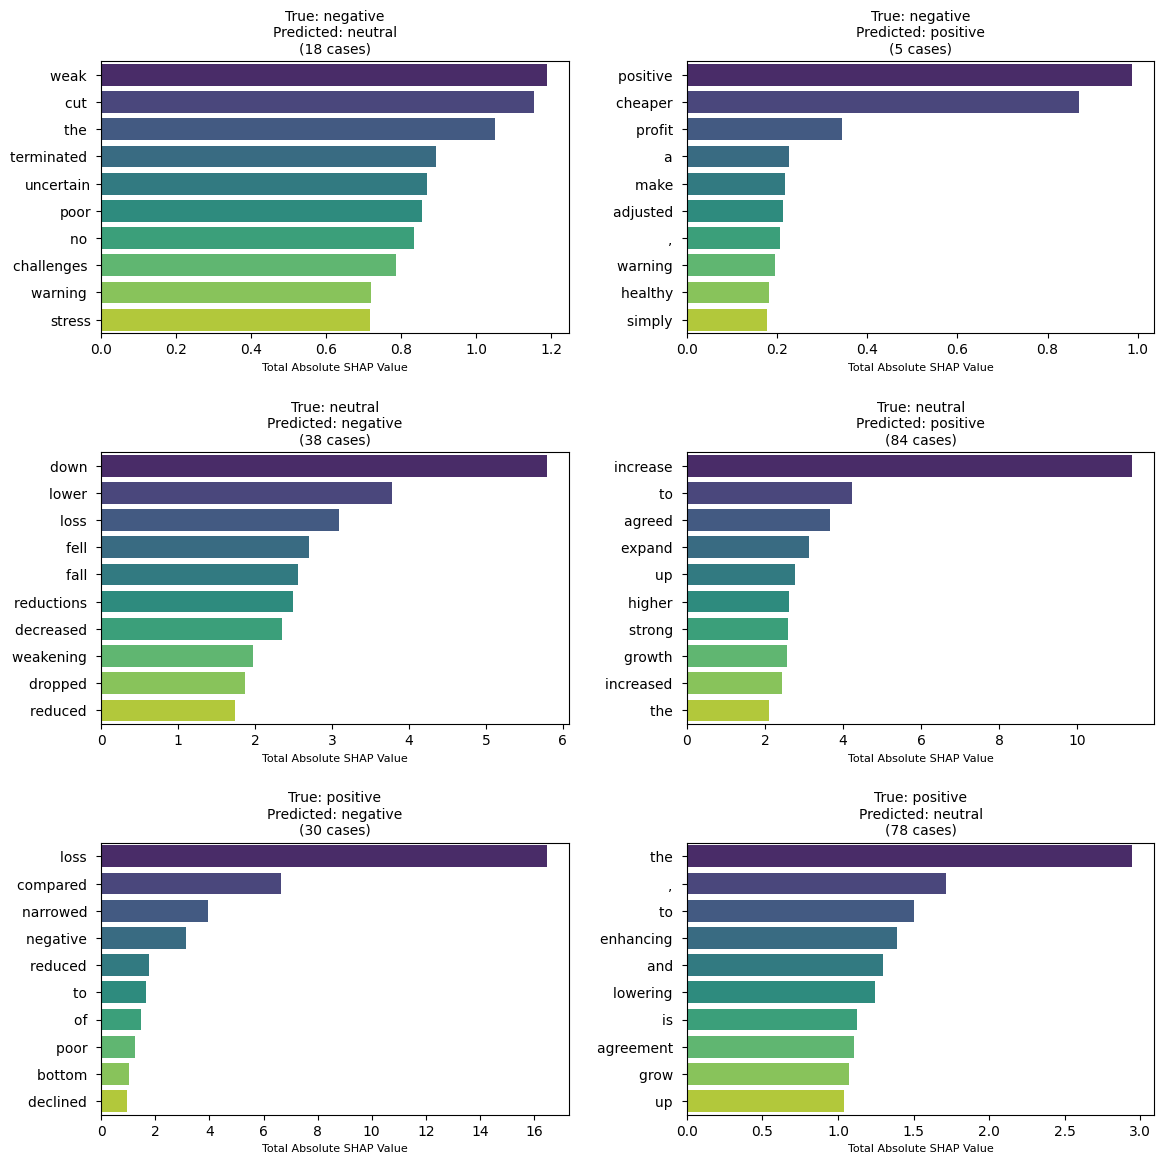

In [41]:
# --- Setup for Data Collection ---
# We'll store the results of each analysis in these lists
results_for_table = []
results_for_plotting = []

# --- Loop through all incorrect cases to collect data ---
for true_label_str in label_encoder.classes_:
    for pred_label_str in label_encoder.classes_:
        if true_label_str == pred_label_str:
            continue

        # --- Step 1: Isolate the Specific Error Type ---
        true_label_int = label_encoder.transform([true_label_str])[0]
        pred_label_int = label_encoder.transform([pred_label_str])[0]

        error_indices = np.where(
            (true_labels_encoded == true_label_int) & (predictions_encoded == pred_label_int)
        )[0]
        error_texts = [test_texts[i] for i in error_indices]
        
        if not error_texts:
            continue
        
        # --- Step 2: Calculate SHAP Values ---
        shap_explanations = explainer(error_texts)
        shap_values_for_error_class = shap_explanations[:, :, pred_label_int].values

        # --- Step 3: Aggregate Word Importance ---
        word_importance = defaultdict(float)
        tokenized_texts = shap_explanations.data
        for i in range(len(tokenized_texts)):
            tokens = tokenized_texts[i]
            shap_scores = shap_values_for_error_class[i]
            for token, score in zip(tokens, shap_scores):
                if isinstance(token, str) and (token.startswith(('[', '#')) or token in ".,!?;:'"):
                    continue
                word_importance[str(token).lower()] += abs(score)

        # --- Step 4: Store Results for Later ---
        importance_df = pd.DataFrame(
            list(word_importance.items()), 
            columns=['word', 'total_abs_shap']
        ).sort_values(by='total_abs_shap', ascending=False).head(10)
        
        # Store data for the combined table
        table_title = f"True: {true_label_str}\nPredicted: {pred_label_str}"
        df_for_table = importance_df.copy()
        df_for_table.columns = pd.MultiIndex.from_product([[table_title], df_for_table.columns])
        results_for_table.append(df_for_table)
        
        # Store data and title for the faceted plot
        plot_title = f"True: {true_label_str}\nPredicted: {pred_label_str}\n({len(error_texts)} cases)"
        results_for_plotting.append({'data': importance_df, 'title': plot_title})

# --- Display the Combined Table ---
if results_for_table:
    print(f"--- Top 10 Culprit Words For Each Error Type (Model: {MODEL_NAME}) ---")
    combined_table = pd.concat(results_for_table, axis=1)
    display(combined_table)
else:
    print("No systematic errors found to display.")

# --- Create the Faceted Graph ---
if results_for_plotting:
    print("\n--- Visual Summary of Error Causes ---")
    num_plots = len(results_for_plotting)
    # Adjust grid size based on number of plots
    ncols = 2
    nrows = (num_plots + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

    for i, res in enumerate(results_for_plotting):
        ax = axes[i]
        sns.barplot(x='total_abs_shap', y='word', data=res['data'], palette='viridis', ax=ax)
        # More specific title for each subplot
        ax.set_title(res['title'], fontsize=10)
        ax.set_xlabel("Total Absolute SHAP Value", fontsize=8)
        ax.set_ylabel(None)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout(pad=2.0)
    plt.show()